In [97]:
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from time import perf_counter

sys.path.append('./../')  # Needed for importing from simulation_utils.py
from simulation_utils import *

In [98]:
# Define U_A, U_B unitaries
U_A = Rot_X(np.pi / 2)
U_B = Rot_X(- np.pi / 2)

# Create DEJMPS circuit
dejmps_circuit = QuantumCircuit([
    Gate(kron([U_A, U_B, U_A, U_B])),   # Apply U_A, U_B gates on each EPR pair
    Gate(kron([I(), SWAP(), I()])),     # Swap qubits 1B, 2A (arange qubits in order: |1A, 2A, 1B, 2B>)
    Gate(kron([CNOT(), CNOT()])),       # Apply CNOT(1A, 2A) and CNOT(1B, 2B)
    Gate(kron([I(), SWAP(), I()])),     # Swap back qubits 2A, 1B (rearange qubits in order: |1A, 1B, 2A, 2B>)
])

# Construct POVM for the 2nd EPR pair
povm_epr2 = POVM(
    nqubits=4, 
    meas_qubits=[2, 3], 
    partial_trace=True,
)

In [99]:
results = []

for epr_channel_fidelity in np.linspace(0, 1, 11):
    # Create two EPR pairs between Alice and Bob
    epr_1 = epr_2 = werner_state(epr_channel_fidelity)

    # Create ensemble of two EPR pairs 
    # (qubits in order: |1A, 1B, 2A, 2B>)
    rho = kron([epr_1, epr_2])

    # Apply DEJMPS circuit
    rho = dejmps_circuit(rho)

    # Compute probabilities and outcome states 
    # when measuring qubits 2A and 2B
    probs, rho_outs = povm_epr2(rho)

    # Compute fidelity wrt. the Bell state phi_00
    target_state = bell_state()
    fidels = np.array([fidelity(dm, target_state) for dm in rho_outs])

    # Compute probability of success and average fidelity **given** success
    prob_succ = probs[0] + probs[-1]
    fidel_succ = (fidels[0] * probs[0] + fidels[-1] * probs[-1]) / prob_succ

    results.append([epr_channel_fidelity, prob_succ, fidel_succ])

results = np.array(results)

results

array([[0.        , 0.5       , 0.25      ],
       [0.1       , 0.505     , 0.30940594],
       [0.2       , 0.52      , 0.38461538],
       [0.3       , 0.545     , 0.47018349],
       [0.4       , 0.58      , 0.56034483],
       [0.5       , 0.625     , 0.65      ],
       [0.6       , 0.68      , 0.73529412],
       [0.7       , 0.745     , 0.81375839],
       [0.8       , 0.82      , 0.88414634],
       [0.9       , 0.905     , 0.9461326 ],
       [1.        , 1.        , 1.        ]])

In [100]:
def series_to_numpy(s: pd.Series):
    """Converts a `pandas.Series` containing lists to a numpy array by depth-1 list flattening."""
    # NOTE: this function can only be applied to the specific series used here
    return np.array([np.concat(row) for row in s.items()])

def get_prob_succ_mean_sd(df: pd.DataFrame):
    """Computes the mean and standard deviation for the success probability."""
    return [
        1 - (df['M_Alice'] ^ df['M_Bob']).mean(), 
        (df['M_Alice'] ^ df['M_Bob']).std(),
    ]

def get_fidel_succ_mean_sd(df: pd.DataFrame):
    """Computes the mean and the standard deviation for the fidelity given success"""
    return [
        df.query('M_Alice == M_Bob')['Fidelity'].mean(), 
        df.query('M_Alice == M_Bob')['Fidelity'].std(),
    ]

In [101]:

# Read simulation results
data = pd.read_csv('./out.csv')

# Group data by gate and channel fidelity
data = data.groupby(['Gate fidelity', 'EPR channel fidelity'])\

# Compute mean and sd for the success probability
p_succ_mean_sd = data.apply(get_prob_succ_mean_sd, include_groups=False)
p_succ_mean_sd = series_to_numpy(p_succ_mean_sd)

# Compute mean and sd for the success fidelity
f_succ_mean_sd = data.apply(get_fidel_succ_mean_sd, include_groups=False)
f_succ_mean_sd = series_to_numpy(f_succ_mean_sd)

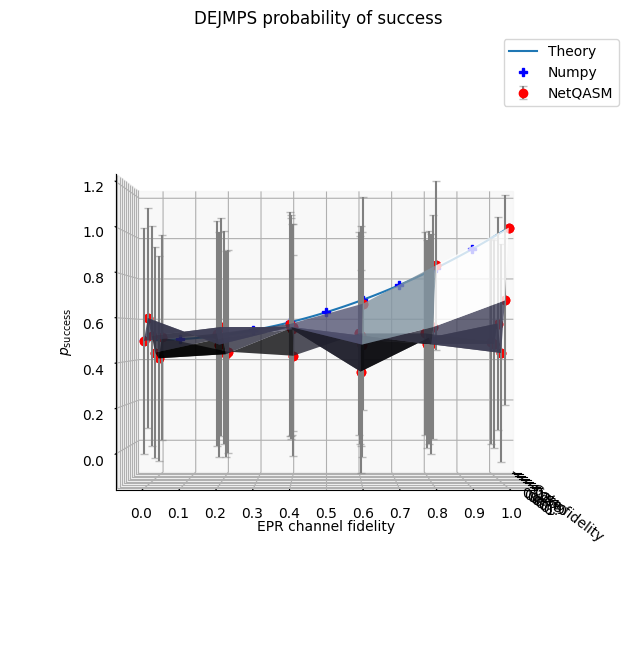

In [102]:
# The probability of measuring a = b is given by the following function:
def prob_succ_theory(epr_channel_fidelity):
    """Theoretical formula for the DEJMPS probability of success"""
    return (1 + epr_channel_fidelity ** 2) / 2

ps = np.linspace(0, 1, 101)

ax = plt.figure(figsize=(8, 8)) \
        .add_subplot(projection='3d')

ax.plot(
    np.ones(len(ps)), ps, prob_succ_theory(ps),
    label='Theory',
)

ax.plot(
    np.ones(len(results)), results[:,0], results[:,1],
    'Pb', label='Numpy',
)

markers, caps, bars = ax.errorbar(
    x=p_succ_mean_sd[:,0], 
    y=p_succ_mean_sd[:,1], 
    z=p_succ_mean_sd[:,2], 
    zerr=p_succ_mean_sd[:,3],
    capsize=3, fmt="ro", ecolor = "grey",
    label='NetQASM',
)
[bar.set_alpha(0.5) for bar in bars]
[cap.set_alpha(0.5) for cap in caps]
[bar.set_linestyle(':') for bar in bars]

ax.plot(
    p_succ_mean_sd[:,0],
    p_succ_mean_sd[:,1],
    p_succ_mean_sd[:,2],
    'ro'
)

# Plot as surface
x = np.unique(p_succ_mean_sd[:,0])
y = np.unique(p_succ_mean_sd[:,1])
z = np.reshape(p_succ_mean_sd[:,2], (len(x), len(y)))

x, y = np.meshgrid(x, y)
x, y = x.T, y.T  # works for some reason, idk why

ax.plot_surface(
    x, y, z,
    cmap='bone',
    alpha=0.8,
)

ax.set_title('DEJMPS probability of success')
ax.set_xlabel('Gate fidelity')
ax.set_ylabel('EPR channel fidelity')
ax.set_zlabel(r'$p_\text{success}$')
ticks = np.arange(11)/10
ax.set_xticks(ticks, ticks)
ax.set_yticks(ticks, ticks)
ax.legend()
# Change camera viewpoint of 3D plot
ax.view_init(azim=-0, elev=0)
plt.show()

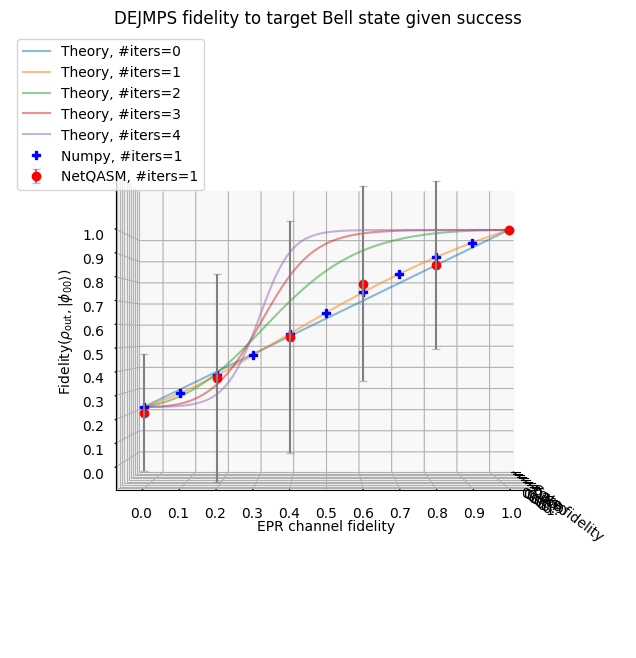

In [103]:
def initial_fidelity(p):
    return (1 + 3 * p) / 4

def fidelity_succ_theory(p, niters: int=0):
    """Theoretical formula for the DEJMPS fidelity given protocol success"""
    dm = werner_state(p)
    A = fidelity(dm, bell_state(0, 0))
    B = fidelity(dm, bell_state(1, 1))
    C = fidelity(dm, bell_state(1, 0))
    D = fidelity(dm, bell_state(0, 1))

    for _ in range(niters):
        N = (A + B) ** 2 + (C + D) ** 2
        A = (A ** 2 + B ** 2) / N
        B = (2 * C * D) / N
        C = (C ** 2 + D ** 2) / N
        D = (2 * A * B) / N

    return A

ps = np.linspace(0, 1, 101)

ax = plt.figure(figsize=(8, 8)) \
        .add_subplot(projection='3d')

for niters in range(0, 5):
    foo = np.vectorize(lambda p: fidelity_succ_theory(p, niters))
    plt.plot(
        np.ones(len(ps)), ps, foo(ps),
        alpha=0.5,
        label=f'Theory, #iters={niters}',
    )

ax.plot(
    np.ones(len(results)), results[:,0], results[:,2], 
    'Pb', label='Numpy, #iters=1',
)




markers, caps, bars = ax.errorbar(
    x=f_succ_mean_sd[-6:,0],
    y=f_succ_mean_sd[-6:,1],
    z=f_succ_mean_sd[-6:,2],
    zerr=f_succ_mean_sd[-6:,3],
    capsize=3, fmt="ro", ecolor = "grey",
    label='NetQASM, #iters=1'
)
[bar.set_alpha(0.5) for bar in bars]
[cap.set_alpha(0.5) for cap in caps]
[bar.set_linestyle(':') for bar in bars]

# ax.plot(
#     f_succ_mean_sd[-6:,0],
#     f_succ_mean_sd[-6:,1],
#     f_succ_mean_sd[-6:,2],
#     'ro',
#     label='NetQASM, #iters=1'
# )

# # Plot as surface
# x = np.unique(f_succ_mean_sd[:,0])
# y = np.unique(f_succ_mean_sd[:,1])
# z = np.reshape(f_succ_mean_sd[:,2], (len(x), len(y)))

# x, y = np.meshgrid(x, y)
# x, y = x.T, y.T  # works for some reason, idk why

# ax.plot_surface(
#     x, y, z,
#     cmap='bone',
#     alpha=0.8,
# )


ax.set_title('DEJMPS fidelity to target Bell state given success')
ax.set_xlabel('Gate fidelity')
ax.set_ylabel('EPR channel fidelity')
ax.set_zlabel(r'$\text{Fidelity}(\rho_\text{out}, \vert\phi_{00}\rangle)$')
ticks = np.arange(11)/10
ax.set_xticks(ticks, ticks)
ax.set_yticks(ticks, ticks)
ax.set_zticks(ticks, ticks)
ax.legend()
# Change camera viewpoint of 3D plot
ax.view_init(azim=-0, elev=0)
plt.show()

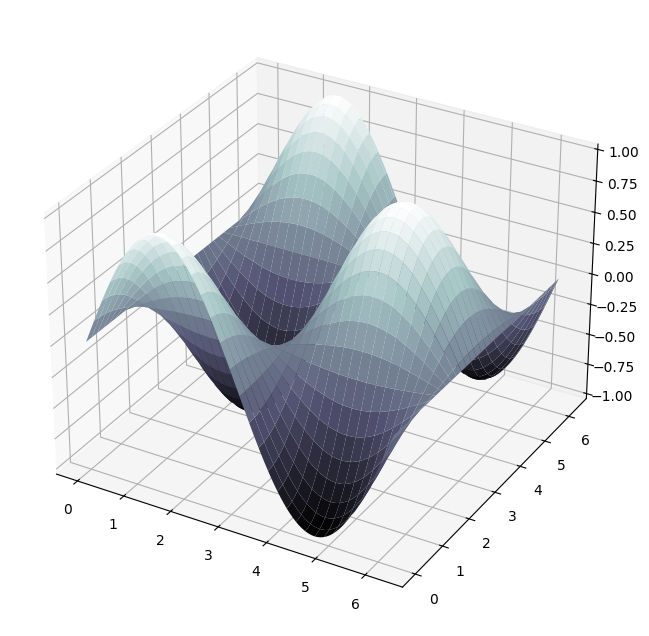

In [104]:
# Example of 3D plot

ax = plt.figure(figsize=(8, 8)) \
        .add_subplot(projection='3d')

x, y = np.meshgrid(np.linspace(0, 2 * np.pi, 101), np.linspace(0, 2 * np.pi, 101))
ax.plot_surface(
    x, y, 
    np.sin(x) * np.cos(y),
    cmap='bone',
    alpha=1.0,
)
ax.view_init(azim=-60, elev=30)
plt.show()

In [105]:
# data = pd.read_csv('./out.csv')
# data = data.sort_values('EPR channel fidelity')
# data = data.query('`Gate fidelity` == 1.0')


# data = data[['Gate fidelity', 'EPR channel fidelity', 'Sample index', 'M_Alice', 'M_Bob', 'Fidelity']]

# n = [-1]
# def foo(_):
#     n[0] += 1
#     return n[0]


# data = data.rename(index=foo)

# data['Sample index'] = np.arange(2400) % 400

# data.to_csv('./out_dejmps.csv', mode='a')
# data